### Assignment 1 (2 scores):
- Use Numpy only to implement the Gaussian Mixture Model.
- Train Gaussian Mixture Model with EM method.

In [79]:
import numpy as np

In [80]:
class GaussianMixture:
    def __init__(self, n_components, max_iter=100, comp_names=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.comp_names = comp_names
        self.pi = [1/self.n_components for _ in range(self.n_components)]
        self.log_likelihood = []

    def multivariate_normal(self, X, mu, cov):
        D = X.shape[1] 
        diff = X - mu
        det_cov = np.linalg.det(cov)
        inv_cov = np.linalg.inv(cov)

        norm_const = 1 / ((2 * np.pi) ** (D / 2) * (det_cov ** 0.5))
        exponent_i = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
        return norm_const * np.exp(-0.5 * exponent_i)

    def fit(self, X):
        new_X = np.array_split(X, self.n_components)
        self.mu = [np.mean(x, axis=0) for x in new_X]
        self.cov = [np.cov(x.T) for x in new_X] 
        self.pi = [1 / self.n_components for _ in range(self.n_components)]

        for i in range(self.max_iter):
            # E-step
            self.r = np.zeros((X.shape[0], self.n_components))
            for k in range(self.n_components):
                self.r[:, k] = self.pi[k] * self.multivariate_normal(X, self.mu[k], self.cov[k])
            self.r /= self.r.sum(axis=1, keepdims=True)

            # Log-likelihood
            likelihood_matrix = np.zeros((X.shape[0], self.n_components))
            for k in range(self.n_components):
                likelihood_matrix[:, k] = self.pi[k] * self.multivariate_normal(X, self.mu[k], self.cov[k])
            log_likelihood = np.sum(np.log(likelihood_matrix.sum(axis=1)))
            self.log_likelihood.append(log_likelihood)
            print(f"Iteration {i + 1}, Log Likelihood: {log_likelihood}")
            #Early stopping 
            if i > 0:
                if abs(self.log_likelihood[i] - self.log_likelihood[i-1]) < 1e-4:
                    print(f"Converged at iteration {i + 1}")
                    break

            # M-step
            N_k = np.sum(self.r, axis=0)
            self.mu = []
            for k in range(self.n_components):
                weighted_sum = np.dot(self.r[:, k], X)
                self.mu.append(weighted_sum / N_k[k])

            self.cov = []
            for k in range(self.n_components):
                diff = X - self.mu[k]
                weighted_cov = np.dot(self.r[:, k] * diff.T, diff) / N_k[k]
                self.cov.append(weighted_cov)
            
            self.pi = N_k / X.shape[0]

    def predict(self, X):
        probas = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            probas[:, k] = self.pi[k] * self.multivariate_normal(X, self.mu[k], self.cov[k])
        clusters = np.argmax(probas, axis=1)
        cluster_labels = [self.comp_names[i] for i in clusters]
        return cluster_labels

### Assignment 2 (2 scores):

Use the Gaussian Mixture Model to filter out background of a given image.

In [81]:
import cv2
import matplotlib.pyplot as plt

In [82]:
image = cv2.imread('cow.jpg')  
image.shape

(196, 300, 3)

In [83]:
img_flat = image.reshape(-1, 3) 
img_flat.shape

(58800, 3)

Iteration 1, Log Likelihood: -597939.6313784062
Iteration 2, Log Likelihood: -547279.9492329767
Iteration 3, Log Likelihood: -539487.2601552459
Iteration 4, Log Likelihood: -538020.7372083523
Iteration 5, Log Likelihood: -537537.8687775488
Iteration 6, Log Likelihood: -537389.8869047029
Iteration 7, Log Likelihood: -537348.8972056924
Iteration 8, Log Likelihood: -537337.9632452414
Iteration 9, Log Likelihood: -537335.1057923317
Iteration 10, Log Likelihood: -537334.3691730561
Iteration 11, Log Likelihood: -537334.1808135894
Iteration 12, Log Likelihood: -537334.1328598325
Iteration 13, Log Likelihood: -537334.1206793364
Iteration 14, Log Likelihood: -537334.1175890374
Iteration 15, Log Likelihood: -537334.1168054695
Iteration 16, Log Likelihood: -537334.1166068445
Iteration 17, Log Likelihood: -537334.1165565084
Converged at iteration 17


Text(0, 0.5, 'Log Likelihood')

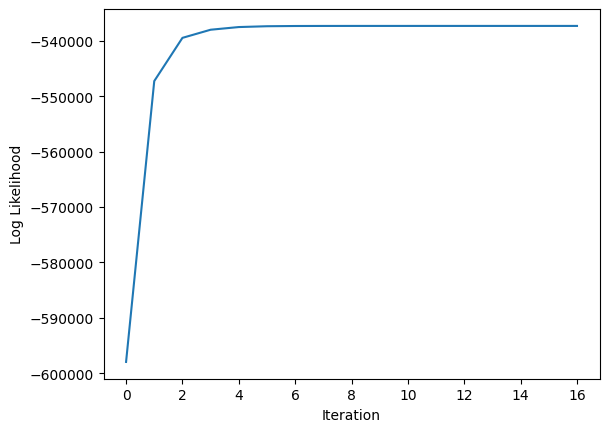

In [84]:
gmm = GaussianMixture(n_components=2, comp_names=[0, 255])
gmm.fit(img_flat)

plt.plot(gmm.log_likelihood)
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')

In [85]:
labels = gmm.predict(img_flat)
len(labels), {k: labels.count(k) for k in set(labels)}

(58800, {0: 51586, 255: 7214})

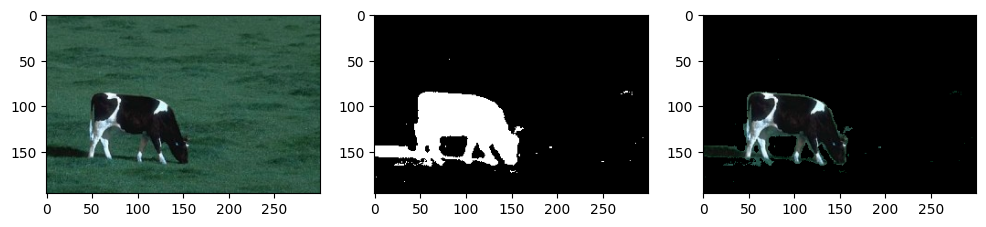

In [86]:
mask = np.array(labels, dtype=np.uint8).reshape(image.shape[:2]) #(H,W)
mask = np.stack([mask] * 3, axis=-1) #(H,W,3)
foreground = image * (mask // 255)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(mask)
plt.subplot(1,3,3)
plt.imshow(foreground)